<a href="https://colab.research.google.com/github/toraaglobal/deeplearning/blob/pytorch/PyTorch_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch playground

In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x

model = FMNIST()

In [5]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

- The only change we have made to the code is that we are going to track the training loss, the testing loss and the accuracy across the 30 epochs.
- We'll print out the train loss, the test loss and the accuracy after each epoch.
- Because we are running this over 30 epochs this will take a bit longer to run - approx 15 minutes.

In [6]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 30
train_tracker, test_tracker, accuracy_tracker = [], [], []


for i in range(num_epochs):
    cum_loss = 0
    
    for batch, (images, labels) in enumerate(trainloader,1):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
    
    train_tracker.append(cum_loss/len(trainloader))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(trainloader)} | ",end='')
    
    test_loss = 0
    num_correct = 0
    total = 0
    
    for batch, (images, labels) in enumerate(testloader,1):
        images = images.to(device)
        labels = labels.to(device)
        
        logps = model(images)
        batch_loss = criterion(logps, labels)        
        test_loss += batch_loss.item()
        
        output = torch.exp(logps)
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
    
    test_tracker.append(test_loss/len(testloader))
    print(f"Test loss: {test_loss/len(testloader)} | ", end='')
    accuracy_tracker.append(num_correct/total)
    print(f'Accuracy : {num_correct/total}')        
print(f'\nNumber correct : {num_correct}, Total : {total}')
print(f'Accuracy of the model after 30 epochs on the 10000 test images: {num_correct * 100 / total}% ')
    
    

Epoch(1/30) | Training loss: 1.033083722853203 | Test loss: 0.6478889252349829 | Accuracy : 0.7613
Epoch(2/30) | Training loss: 0.559734877111561 | Test loss: 0.5414156454383947 | Accuracy : 0.8038
Epoch(3/30) | Training loss: 0.4903994125883971 | Test loss: 0.49719916521363955 | Accuracy : 0.8192
Epoch(4/30) | Training loss: 0.45546039637090807 | Test loss: 0.47290265901832823 | Accuracy : 0.8297
Epoch(5/30) | Training loss: 0.43094317878741445 | Test loss: 0.4570433107341171 | Accuracy : 0.8354
Epoch(6/30) | Training loss: 0.4133367527014157 | Test loss: 0.448315643485944 | Accuracy : 0.8358
Epoch(7/30) | Training loss: 0.3997603754149571 | Test loss: 0.4296641906925068 | Accuracy : 0.8475
Epoch(8/30) | Training loss: 0.38798339763429884 | Test loss: 0.42926957956544914 | Accuracy : 0.8436
Epoch(9/30) | Training loss: 0.3774288168816424 | Test loss: 0.41140441473122613 | Accuracy : 0.8524
Epoch(10/30) | Training loss: 0.36848884409488136 | Test loss: 0.42722994848421425 | Accuracy : 

- Has the accuracy of the model increased?
- Now plot the training loss vs the test loss over 30 epochs.

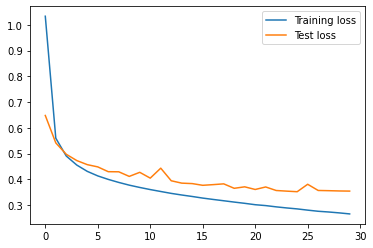

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(test_tracker, label='Test loss')
plt.legend()

- Now add the accuracy to the mix.

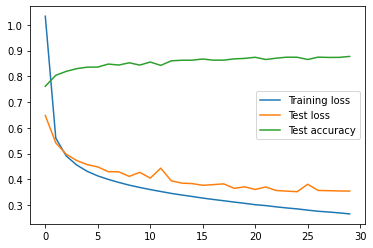

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(test_tracker, label='Test loss')
plt.plot(accuracy_tracker, label='Test accuracy')
plt.legend()

## Further challenges and experiments
- Can you get better accuracy from a model if you :
    - Add more layers?
    - Change the number of nodes in the layers?
    - Train over fewer/higher epochs?
    
- Can you improve on your results if you add additional layers like [Dropout](https://pytorch.org/docs/master/nn.html#torch.nn.Dropout)